***
<font size="6"><center><b> HD-CapsNet: A Hierarchical Deep Capsule Network for Image Classification </b></center></font>
***

**Changing Model Architecture**
- **(Mod-3.1)** 32D>16D>8D (Coarse>Medium>FINE) use skip connections between Secondary Capsules $Concatenate([P_{caps}, S_{coarse}])$ > input for $S_{medium}$ and $Concatenate([P_{caps}, S_{medium}])$ > input for $S_{fine}$
- With $L_{Cons}$

# Files and Libraries

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras import regularizers, optimizers
from tensorflow.keras import backend as K

import tensorflow_docs as tfdocs
import tensorflow_docs.plots

# Supporting Libraries:
    #Mathplot lib for ploting graphs
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
    # numpy and pandas
import numpy as np
import pandas as pd
    #system
import os
import sys
import csv
    #import other libraries
import math
import random
from datetime import datetime
from treelib import Tree
    # ML model, Dataset and evalution metrics
sys.path.append('../../') ### adding system parth for src folder
from src import datasets # load datasets
from src import MixUp # load datasets
from src import MixUp_add_loss # load datasets
from src import metrics # load hierarchcial metrics
from src import sysenv # load hierarchcial metrics
from src import models # load machine learning models

    ## Tensorflow_docs
import tensorflow_docs as tfdocs
import tensorflow_docs.plots

    # Auto reload local libraries if updated
%load_ext autoreload
%autoreload 2

# System information & GPU growth

In [2]:
systeminfo = sysenv.systeminfo()
print(systeminfo)


• Computer Name = SARUMAN
• Working Directory = D:\knoor\Deep Learning with Python\RunningOnServer\HD-CapsNet_MOD\Training_and_Analysis\6_Stanford_Cars
• Python Version = 3.8.12 (default, Oct 12 2021, 03:01:40) [MSC v.1916 64 bit (AMD64)]
• TensorFlow Version = 2.8.0
• Keras Version = 2.8.0
• Current Environment = Anaconda Environment Name : D:\knoor\AnacondaEnvironment\py38tf28


In [3]:
gpus = "0,1,2,3,4,5,6,7" ## Selecting Available gpus (Multi-GPUS)
gpus = "4" ## Selecting Available gpus (Single GPU)
gpugrowth = sysenv.gpugrowth(gpus = gpus) ## Limiting GPUS from OS environment
gpugrowth.memory_growth() #GPU memory growth

Following GPUS are selected =  4
Done: GPU PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
1 Physical GPUs, 1 Logical GPUs


# Parameters

In [4]:
train_params = {"n_epochs" : 100,
                "batch_size": 16,
                "lr": 0.001, # Initial learning rate
                "lr_decay": 0.95, # Learning rate decay
                "decay_exe": 9, #learning rate decay execution epoch after
               }
model_params = {"optimizer": tf.keras.optimizers.Adam(train_params['lr']),
                "loss_function": models.MarginLoss(),
               }

# log directory

In [5]:
directory = sysenv.log_dir('6_Stanford_Cars/HD_CapsNet/Mod_3_1')

FOLDER CREATED =  ../../logs/6_Stanford_Cars/HD_CapsNet/Mod_3_1


# Import Dataset : Stanford_Cars

In [6]:
training_dataset,  test_dataset, val_dataset, tree, info = datasets.Stanford_Cars(image_size=(64, 64), 
                                                                                  batch_size=train_params['batch_size'],
                                                                                  data_aug = 'mixup',
                                                                                  data_normalizing = None)

In [7]:
for x,y in training_dataset.take(1):
    image_shape = x.shape[1:]
    coarse_label_shape = y[0].shape[1:]
    medium_label_shape = y[1].shape[1:]
    fine_label_shape = y[2].shape[1:]

## Learning Rate Decay Scheduler

In [8]:
def scheduler(epoch):
    learning_rate_init = train_params["lr"]
    
    if epoch > train_params["decay_exe"]:
        learning_rate_init = train_params["lr"] * (train_params["lr_decay"] ** (epoch-9))
        
    tf.summary.scalar('learning rate', data=learning_rate_init, step=epoch)
        
    return learning_rate_init

# Model Architecture

## Loss Function

In [9]:
## For Dynamic LossWeights
initial_lw = models.initial_lw({"coarse": info['Num_Coarse'],
                                "medium": info['Num_Medium'],
                                "fine": info['Num_Fine']})

lossweight = {'coarse_lw' : K.variable(value = initial_lw['coarse'], dtype="float32", name="coarse_lw"),
             'medium_lw' : K.variable(value = initial_lw['medium'], dtype="float32", name="medium_lw"),
             'fine_lw' : K.variable(value = initial_lw['fine'], dtype="float32", name="fine_lw"),
              'decoder_lw' : 0.0
             }

In [10]:
Matrix_coarse_to_medium_OneHot = tf.constant(info['Matrix_coarse_to_medium'], dtype=tf.float32)
Matrix_medium_to_fine_OneHot = tf.constant(info['Matrix_medium_to_fine'], dtype=tf.float32)

In [11]:
def margin_loss(y_true, y_proba):
    
    present_error_raw = tf.square(tf.maximum(0., 0.9 - y_proba), name="present_error_raw")
    absent_error_raw = tf.square(tf.maximum(0., y_proba - 0.1), name="absent_error_raw")
    L = tf.add(y_true * present_error_raw, 0.5 * (1.0 - y_true) * absent_error_raw,name="L")
    total_marginloss = tf.reduce_sum(L, axis=1, name="margin_loss")

    return total_marginloss


def consistency_check(y_pred_ancestor,y_pred_current,lookup_matrix,num_class_current):
    pred_max_ancestor = tf.argmax(y_pred_ancestor,axis=1)
    pred_max_current = tf.argmax(y_pred_current,axis=1)
    
    consistant_check = tf.gather(lookup_matrix, indices=pred_max_ancestor)*tf.one_hot(pred_max_current,num_class_current)
    
    return tf.reduce_sum(consistant_check,1)

def get_consistency(y_true_ancestor, y_pred, lookup_matrix):
    '''
    Get consistency based on 2 levels
    Provide ture levels for the level above, predictions for the current level and a look up metrix
    '''
    y_prob = tf.math.divide(y_pred,tf.reshape(tf.reduce_sum(y_pred,-1),(-1,1),name='reshape'),name='Probability')
    
    index_for_predictions = tf.cast(tf.math.argmax(y_true_ancestor,axis=1),dtype= 'int32')
    consistent_fine = tf.gather(lookup_matrix, indices=index_for_predictions) * y_prob
    Consistency_sum_array = tf.reduce_sum(consistent_fine, axis =1)
    
    return tf.abs(1-Consistency_sum_array)

def CustomLoss(y_true_c, y_true_m, y_true_f, y_pred_c, y_pred_m, y_pred_f, LW_C, LW_M, LW_F,
               number_of_classes_m, number_of_classes_f, C_Weight=0.2):
    
    con_m = consistency_check(y_pred_c,y_pred_m,Matrix_coarse_to_medium_OneHot,num_class_current=number_of_classes_m)
    con_m_not = tf.abs(con_m-1)
    
    con_f = consistency_check(y_pred_m,y_pred_f,Matrix_medium_to_fine_OneHot,num_class_current=number_of_classes_f)
    con_f_not = tf.abs(con_f-1)
    
    con_sum_m = get_consistency(y_true_c,y_pred_m,Matrix_coarse_to_medium_OneHot)
    con_sum_f = get_consistency(y_true_m,y_pred_f,Matrix_medium_to_fine_OneHot)
    
    medium_lvl_cosistency = con_sum_m * con_m_not
    fine_lvl_cosistency = con_sum_f * con_f_not    
   
    ML_c = margin_loss(y_true_c, y_pred_c)*LW_C
    ML_m = LW_M*((1-C_Weight)*(margin_loss(y_true_m, y_pred_m))+C_Weight*(medium_lvl_cosistency))
    ML_f = LW_F*((1-C_Weight)*(margin_loss(y_true_f, y_pred_f))+C_Weight*(fine_lvl_cosistency))
    
    batch_loss = ML_c + ML_m+ ML_f

    return tf.reduce_mean(batch_loss)

## Architecture

In [12]:
def get_compiled_model():
    
    ## Calling the HD-CapsNet Model
    model = models.HD_CapsNet_Mod_3_3(input_shape     = image_shape, 
                                      input_shape_yc  = coarse_label_shape,
                                      input_shape_ym  = medium_label_shape,
                                      input_shape_yf  = fine_label_shape, 
                                      no_coarse_class = info['Num_Coarse'], 
                                      no_medium_class = info['Num_Medium'], 
                                      no_fine_class   = info['Num_Fine'],
                                      PCap_n_dims     = 8, 
                                      SCap_f_dims     = 8, 
                                      SCap_m_dims     = 16, 
                                      SCap_c_dims     = 32)
    
    ## Saving Model Architecture
    keras.utils.plot_model(model, to_file = directory+"/Architecture.png", show_shapes=True)
    
    ## Add Loss for Model
    model.add_loss(CustomLoss(y_true_c            = model.inputs[1], 
                              y_true_m            = model.inputs[2], 
                              y_true_f            = model.inputs[3], 
                              y_pred_c            = model.output[0], 
                              y_pred_m            = model.output[1], 
                              y_pred_f            = model.output[2], 
                              LW_C                = lossweight['coarse_lw'], 
                              LW_M                = lossweight['medium_lw'], 
                              LW_F                = lossweight['fine_lw'],
                              number_of_classes_m = info['Num_Medium'], 
                              number_of_classes_f = info['Num_Fine'], 
                              C_Weight            =0.2)
                  )
    
    ## Compile Model
    model.compile(optimizer='adam',                  
                  metrics={'prediction_fine': 'accuracy',
                           'prediction_medium': 'accuracy',
                           'prediction_coarse': 'accuracy'}
                 )
    return model

## Compile Model

In [13]:
model = get_compiled_model()

In [14]:
model.summary()
# keras.utils.plot_model(model, to_file = directory+"/Architecture.png", show_shapes=True)

Model: "HD-CapsNet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Input_Image (InputLayer)       [(None, 64, 64, 3)]  0           []                               
                                                                                                  
 block1_conv1 (Conv2D)          (None, 64, 64, 64)   1792        ['Input_Image[0][0]']            
                                                                                                  
 batch_normalization (BatchNorm  (None, 64, 64, 64)  256         ['block1_conv1[0][0]']           
 alization)                                                                                       
                                                                                                  
 block1_conv2 (Conv2D)          (None, 64, 64, 64)   36928       ['batch_normalization[0]

                                                                                                  
 prediction_medium (LengthLayer  (None, 113)         0           ['s_caps_medium[0][0]']          
 )                                                                                                
                                                                                                  
 prediction_fine (LengthLayer)  (None, 196)          0           ['s_caps_fine[0][0]']            
                                                                                                  
 tf.math.argmax_4 (TFOpLambda)  (None,)              0           ['input_yc[0][0]']               
                                                                                                  
 tf.math.reduce_sum_2 (TFOpLamb  (None,)             0           ['prediction_medium[0][0]']      
 da)                                                                                              
          

 )                                                                                                
                                                                                                  
 tf.math.square_2 (TFOpLambda)  (None, 113)          0           ['tf.math.maximum_2[0][0]']      
                                                                                                  
 tf.math.multiply_11 (TFOpLambd  (None, 113)         0           ['tf.math.subtract_9[0][0]']     
 a)                                                                                               
                                                                                                  
 tf.math.square_3 (TFOpLambda)  (None, 113)          0           ['tf.math.maximum_3[0][0]']      
                                                                                                  
 tf.math.reduce_sum_3 (TFOpLamb  (None,)             0           ['tf.math.multiply_2[0][0]']     
 da)      

 )                                                                                                
                                                                                                  
 tf.math.multiply_6 (TFOpLambda  (None, 13)          0           ['input_yc[0][0]',               
 )                                                                'tf.math.square[0][0]']         
                                                                                                  
 tf.math.multiply_8 (TFOpLambda  (None, 13)          0           ['tf.math.multiply_7[0][0]',     
 )                                                                'tf.math.square_1[0][0]']       
                                                                                                  
 tf.math.reduce_sum_7 (TFOpLamb  (None,)             0           ['tf.math.add_1[0][0]']          
 da)                                                                                              
          

## Data Augmentation

## Training Pipeline Alignment

In [15]:
#### Matching the pipeling with model inputs
def pipeline_multi_input_output(image, label):
    label_0 = label[0]
    label_1 = label[1]
    label_2 = label[2]
    return (image, label_0, label_1, label_2), (label_0, label_1, label_2)

training_dataset_match = training_dataset.map(pipeline_multi_input_output) ## Mixup dataset
val_dataset_match = val_dataset.map(pipeline_multi_input_output) ## Val Dataset

## Callback

In [16]:
tb = keras.callbacks.TensorBoard(directory+'./tb_logs'+ datetime.now().strftime("%Y%m%d-%H%M%S"))
log = keras.callbacks.CSVLogger(directory+'/log.csv', append=True)

checkpoint = keras.callbacks.ModelCheckpoint(directory+'/epoch-best.h5',
                                             monitor='val_prediction_fine_accuracy',
                                             save_best_only=True, 
                                             save_weights_only=True, 
                                             verbose=1)

change_lw = models.LossWeightsModifier(lossweight = lossweight,
                                       initial_lw = initial_lw,
                                       directory = directory)

lr_decay = keras.callbacks.LearningRateScheduler(scheduler)

## Model Training

In [17]:
model_save_dir = str(directory+'/trained_model.h5')
try:
    model.load_weights(model_save_dir)
except:
    history = model.fit(training_dataset_match,
                        epochs = train_params["n_epochs"],
                        validation_data = val_dataset_match,
                        callbacks = [tb,log,change_lw,lr_decay,checkpoint],
                        verbose=1)
    
    model.save_weights(model_save_dir)

Epoch 1/100
509/509 [==============================] - ETA: 0s - loss: 0.6287 - prediction_coarse_accuracy: 0.2248 - prediction_medium_accuracy: 0.0253 - prediction_fine_accuracy: 0.0101
  • Coarse Accuracy = 22.48% | Val_Accuracy = 16.74% | LossWeight = 0.42 
  • Medium Accuracy = 2.53% | Val_Accuracy = 3.01% | LossWeight = 0.36 
  • Fine   Accuracy = 1.01% | Val_Accuracy = 0.52% | LossWeight = 0.22 

Epoch 1: val_prediction_fine_accuracy improved from -inf to 0.00522, saving model to ../../logs/6_Stanford_Cars/HD_CapsNet/Mod_3_1\epoch-best.h5
509/509 [==============================] - 363s 580ms/step - loss: 0.6287 - prediction_coarse_accuracy: 0.2248 - prediction_medium_accuracy: 0.0253 - prediction_fine_accuracy: 0.0101 - val_loss: 0.6306 - val_prediction_coarse_accuracy: 0.1674 - val_prediction_medium_accuracy: 0.0301 - val_prediction_fine_accuracy: 0.0052 - lr: 0.0010
Epoch 2/100
509/509 [==============================] - ETA: 0s - loss: 0.5292 - prediction_coarse_accuracy: 0.281

509/509 [==============================] - 338s 599ms/step - loss: 0.3787 - prediction_coarse_accuracy: 0.6108 - prediction_medium_accuracy: 0.2785 - prediction_fine_accuracy: 0.2273 - val_loss: 0.4249 - val_prediction_coarse_accuracy: 0.4348 - val_prediction_medium_accuracy: 0.1274 - val_prediction_fine_accuracy: 0.0806 - lr: 0.0010
Epoch 10/100
509/509 [==============================] - ETA: 0s - loss: 0.3464 - prediction_coarse_accuracy: 0.6896 - prediction_medium_accuracy: 0.3594 - prediction_fine_accuracy: 0.2979
  • Coarse Accuracy = 68.96% | Val_Accuracy = 42.04% | LossWeight = 0.30 
  • Medium Accuracy = 35.94% | Val_Accuracy = 12.26% | LossWeight = 0.42 
  • Fine   Accuracy = 29.79% | Val_Accuracy = 7.59% | LossWeight = 0.28 

Epoch 10: val_prediction_fine_accuracy did not improve from 0.08060
509/509 [==============================] - 364s 625ms/step - loss: 0.3464 - prediction_coarse_accuracy: 0.6896 - prediction_medium_accuracy: 0.3594 - prediction_fine_accuracy: 0.2979 - v

509/509 [==============================] - 296s 523ms/step - loss: 0.1371 - prediction_coarse_accuracy: 0.9482 - prediction_medium_accuracy: 0.9295 - prediction_fine_accuracy: 0.8847 - val_loss: 0.4216 - val_prediction_coarse_accuracy: 0.4771 - val_prediction_medium_accuracy: 0.1928 - val_prediction_fine_accuracy: 0.1448 - lr: 6.6342e-04
Epoch 19/100
509/509 [==============================] - ETA: 0s - loss: 0.1250 - prediction_coarse_accuracy: 0.9542 - prediction_medium_accuracy: 0.9429 - prediction_fine_accuracy: 0.9069
  • Coarse Accuracy = 95.42% | Val_Accuracy = 43.78% | LossWeight = 0.37 
  • Medium Accuracy = 94.29% | Val_Accuracy = 18.41% | LossWeight = 0.32 
  • Fine   Accuracy = 90.69% | Val_Accuracy = 13.46% | LossWeight = 0.31 

Epoch 19: val_prediction_fine_accuracy did not improve from 0.15522
509/509 [==============================] - 289s 511ms/step - loss: 0.1250 - prediction_coarse_accuracy: 0.9542 - prediction_medium_accuracy: 0.9429 - prediction_fine_accuracy: 0.906

509/509 [==============================] - ETA: 0s - loss: 0.1002 - prediction_coarse_accuracy: 0.9619 - prediction_medium_accuracy: 0.9603 - prediction_fine_accuracy: 0.9514
  • Coarse Accuracy = 96.19% | Val_Accuracy = 48.73% | LossWeight = 0.45 
  • Medium Accuracy = 96.03% | Val_Accuracy = 18.28% | LossWeight = 0.32 
  • Fine   Accuracy = 95.14% | Val_Accuracy = 14.33% | LossWeight = 0.23 

Epoch 28: val_prediction_fine_accuracy did not improve from 0.15522
509/509 [==============================] - 311s 552ms/step - loss: 0.1002 - prediction_coarse_accuracy: 0.9619 - prediction_medium_accuracy: 0.9603 - prediction_fine_accuracy: 0.9514 - val_loss: 0.4729 - val_prediction_coarse_accuracy: 0.4873 - val_prediction_medium_accuracy: 0.1828 - val_prediction_fine_accuracy: 0.1433 - lr: 3.9721e-04
Epoch 29/100
509/509 [==============================] - ETA: 0s - loss: 0.0977 - prediction_coarse_accuracy: 0.9614 - prediction_medium_accuracy: 0.9583 - prediction_fine_accuracy: 0.9543
  • Co

509/509 [==============================] - 291s 513ms/step - loss: 0.0877 - prediction_coarse_accuracy: 0.9673 - prediction_medium_accuracy: 0.9668 - prediction_fine_accuracy: 0.9632 - val_loss: 0.4821 - val_prediction_coarse_accuracy: 0.4828 - val_prediction_medium_accuracy: 0.1828 - val_prediction_fine_accuracy: 0.1378 - lr: 2.5034e-04
Epoch 38/100
509/509 [==============================] - ETA: 0s - loss: 0.0911 - prediction_coarse_accuracy: 0.9710 - prediction_medium_accuracy: 0.9664 - prediction_fine_accuracy: 0.9617
  • Coarse Accuracy = 97.10% | Val_Accuracy = 48.93% | LossWeight = 0.43 
  • Medium Accuracy = 96.64% | Val_Accuracy = 18.01% | LossWeight = 0.34 
  • Fine   Accuracy = 96.17% | Val_Accuracy = 13.43% | LossWeight = 0.23 

Epoch 38: val_prediction_fine_accuracy did not improve from 0.15522
509/509 [==============================] - 291s 524ms/step - loss: 0.0911 - prediction_coarse_accuracy: 0.9710 - prediction_medium_accuracy: 0.9664 - prediction_fine_accuracy: 0.961

509/509 [==============================] - ETA: 0s - loss: 0.0880 - prediction_coarse_accuracy: 0.9688 - prediction_medium_accuracy: 0.9659 - prediction_fine_accuracy: 0.9597
  • Coarse Accuracy = 96.88% | Val_Accuracy = 49.50% | LossWeight = 0.44 
  • Medium Accuracy = 96.59% | Val_Accuracy = 17.89% | LossWeight = 0.33 
  • Fine   Accuracy = 95.97% | Val_Accuracy = 13.41% | LossWeight = 0.23 

Epoch 47: val_prediction_fine_accuracy did not improve from 0.15522
509/509 [==============================] - 258s 466ms/step - loss: 0.0880 - prediction_coarse_accuracy: 0.9688 - prediction_medium_accuracy: 0.9659 - prediction_fine_accuracy: 0.9597 - val_loss: 0.4804 - val_prediction_coarse_accuracy: 0.4950 - val_prediction_medium_accuracy: 0.1789 - val_prediction_fine_accuracy: 0.1341 - lr: 1.4989e-04
Epoch 48/100
509/509 [==============================] - ETA: 0s - loss: 0.0863 - prediction_coarse_accuracy: 0.9695 - prediction_medium_accuracy: 0.9657 - prediction_fine_accuracy: 0.9603
  • Co

509/509 [==============================] - 207s 372ms/step - loss: 0.0851 - prediction_coarse_accuracy: 0.9741 - prediction_medium_accuracy: 0.9714 - prediction_fine_accuracy: 0.9678 - val_loss: 0.4907 - val_prediction_coarse_accuracy: 0.4848 - val_prediction_medium_accuracy: 0.1900 - val_prediction_fine_accuracy: 0.1366 - lr: 9.4468e-05
Epoch 57/100
509/509 [==============================] - ETA: 0s - loss: 0.0830 - prediction_coarse_accuracy: 0.9752 - prediction_medium_accuracy: 0.9710 - prediction_fine_accuracy: 0.9703
  • Coarse Accuracy = 97.52% | Val_Accuracy = 48.96% | LossWeight = 0.44 
  • Medium Accuracy = 97.10% | Val_Accuracy = 19.18% | LossWeight = 0.35 
  • Fine   Accuracy = 97.03% | Val_Accuracy = 13.78% | LossWeight = 0.21 

Epoch 57: val_prediction_fine_accuracy did not improve from 0.15522
509/509 [==============================] - 209s 375ms/step - loss: 0.0830 - prediction_coarse_accuracy: 0.9752 - prediction_medium_accuracy: 0.9710 - prediction_fine_accuracy: 0.970

509/509 [==============================] - ETA: 0s - loss: 0.0838 - prediction_coarse_accuracy: 0.9780 - prediction_medium_accuracy: 0.9737 - prediction_fine_accuracy: 0.9726
  • Coarse Accuracy = 97.80% | Val_Accuracy = 49.35% | LossWeight = 0.43 
  • Medium Accuracy = 97.37% | Val_Accuracy = 18.41% | LossWeight = 0.35 
  • Fine   Accuracy = 97.26% | Val_Accuracy = 13.58% | LossWeight = 0.22 

Epoch 66: val_prediction_fine_accuracy did not improve from 0.15522
509/509 [==============================] - 248s 449ms/step - loss: 0.0838 - prediction_coarse_accuracy: 0.9780 - prediction_medium_accuracy: 0.9737 - prediction_fine_accuracy: 0.9726 - val_loss: 0.4857 - val_prediction_coarse_accuracy: 0.4935 - val_prediction_medium_accuracy: 0.1841 - val_prediction_fine_accuracy: 0.1358 - lr: 5.6562e-05
Epoch 67/100
509/509 [==============================] - ETA: 0s - loss: 0.0828 - prediction_coarse_accuracy: 0.9752 - prediction_medium_accuracy: 0.9718 - prediction_fine_accuracy: 0.9687
  • Co

509/509 [==============================] - 202s 360ms/step - loss: 0.0839 - prediction_coarse_accuracy: 0.9781 - prediction_medium_accuracy: 0.9725 - prediction_fine_accuracy: 0.9699 - val_loss: 0.4884 - val_prediction_coarse_accuracy: 0.4948 - val_prediction_medium_accuracy: 0.1868 - val_prediction_fine_accuracy: 0.1363 - lr: 3.5648e-05
Epoch 76/100
509/509 [==============================] - ETA: 0s - loss: 0.0826 - prediction_coarse_accuracy: 0.9738 - prediction_medium_accuracy: 0.9703 - prediction_fine_accuracy: 0.9665
  • Coarse Accuracy = 97.38% | Val_Accuracy = 49.35% | LossWeight = 0.44 
  • Medium Accuracy = 97.03% | Val_Accuracy = 18.51% | LossWeight = 0.34 
  • Fine   Accuracy = 96.65% | Val_Accuracy = 13.46% | LossWeight = 0.23 

Epoch 76: val_prediction_fine_accuracy did not improve from 0.15522
509/509 [==============================] - 260s 477ms/step - loss: 0.0826 - prediction_coarse_accuracy: 0.9738 - prediction_medium_accuracy: 0.9703 - prediction_fine_accuracy: 0.966

509/509 [==============================] - ETA: 0s - loss: 0.0824 - prediction_coarse_accuracy: 0.9759 - prediction_medium_accuracy: 0.9709 - prediction_fine_accuracy: 0.9681
  • Coarse Accuracy = 97.59% | Val_Accuracy = 49.13% | LossWeight = 0.42 
  • Medium Accuracy = 97.09% | Val_Accuracy = 18.11% | LossWeight = 0.35 
  • Fine   Accuracy = 96.81% | Val_Accuracy = 13.38% | LossWeight = 0.23 

Epoch 85: val_prediction_fine_accuracy did not improve from 0.15522
509/509 [==============================] - 235s 427ms/step - loss: 0.0824 - prediction_coarse_accuracy: 0.9759 - prediction_medium_accuracy: 0.9709 - prediction_fine_accuracy: 0.9681 - val_loss: 0.4771 - val_prediction_coarse_accuracy: 0.4913 - val_prediction_medium_accuracy: 0.1811 - val_prediction_fine_accuracy: 0.1338 - lr: 2.1344e-05
Epoch 86/100
509/509 [==============================] - ETA: 0s - loss: 0.0816 - prediction_coarse_accuracy: 0.9765 - prediction_medium_accuracy: 0.9730 - prediction_fine_accuracy: 0.9689
  • Co

509/509 [==============================] - 318s 570ms/step - loss: 0.0829 - prediction_coarse_accuracy: 0.9720 - prediction_medium_accuracy: 0.9689 - prediction_fine_accuracy: 0.9643 - val_loss: 0.4789 - val_prediction_coarse_accuracy: 0.4975 - val_prediction_medium_accuracy: 0.1858 - val_prediction_fine_accuracy: 0.1356 - lr: 1.3452e-05
Epoch 95/100
509/509 [==============================] - ETA: 0s - loss: 0.0833 - prediction_coarse_accuracy: 0.9737 - prediction_medium_accuracy: 0.9691 - prediction_fine_accuracy: 0.9677
  • Coarse Accuracy = 97.37% | Val_Accuracy = 49.53% | LossWeight = 0.44 
  • Medium Accuracy = 96.91% | Val_Accuracy = 18.71% | LossWeight = 0.35 
  • Fine   Accuracy = 96.77% | Val_Accuracy = 13.46% | LossWeight = 0.22 

Epoch 95: val_prediction_fine_accuracy did not improve from 0.15522
509/509 [==============================] - 289s 513ms/step - loss: 0.0833 - prediction_coarse_accuracy: 0.9737 - prediction_medium_accuracy: 0.9691 - prediction_fine_accuracy: 0.967

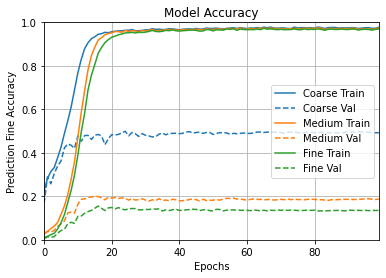

In [18]:
try:
    history_dict = history.history

    plotter = tfdocs.plots.HistoryPlotter()
    plotter.plot({"Coarse": history}, metric = "prediction_coarse_accuracy")
    plotter.plot({"Medium": history}, metric = "prediction_medium_accuracy")
    plotter.plot({"Fine": history}, metric = "prediction_fine_accuracy")
    plt.title("Model Accuracy")
    plt.ylim([0,1])
except:
    print('Trained model weights loaded')

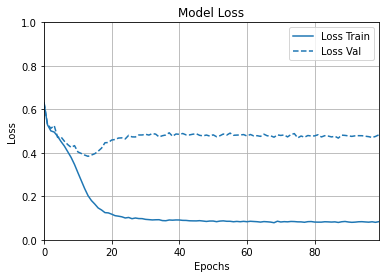

In [19]:
try:
    plotter = tfdocs.plots.HistoryPlotter()
    plotter.plot({"loss": history}, metric = "loss")
    plt.title("Model Loss")
    plt.ylim([0,1])
except:
    print('Trained model weights loaded')

## Model Analysis

In [20]:
final_model = keras.Model(model.inputs[:1], model.output)

lossfn = models.MarginLoss()
final_model.compile(optimizer='adam', 
                    loss={'prediction_fine' : lossfn,
                          'prediction_medium' : lossfn,
                          'prediction_coarse' : lossfn},

                    loss_weights={'prediction_fine' : lossweight['fine_lw'],
                                  'prediction_medium' : lossweight['medium_lw'],
                                  'prediction_coarse' : lossweight['coarse_lw']},

                    metrics={'prediction_fine': 'accuracy',
                             'prediction_medium': 'accuracy',
                             'prediction_coarse': 'accuracy'
                            }
                   )

In [21]:
results = final_model.evaluate(test_dataset)
for n in range(len(results)):
    print(str(n+1)+'.',final_model.metrics_names[n], '==>', results[n])
model_predictions = final_model.predict(test_dataset)

252/252 [==============================] - 26s 93ms/step - loss: 0.5271 - prediction_coarse_loss: 0.3674 - prediction_medium_loss: 0.6229 - prediction_fine_loss: 0.6812 - prediction_coarse_accuracy: 0.4929 - prediction_medium_accuracy: 0.1870 - prediction_fine_accuracy: 0.1350
1. loss ==> 0.5270788073539734
2. prediction_coarse_loss ==> 0.3673955202102661
3. prediction_medium_loss ==> 0.6228743195533752
4. prediction_fine_loss ==> 0.6811504364013672
5. prediction_coarse_accuracy ==> 0.4929122030735016
6. prediction_medium_accuracy ==> 0.18701815605163574
7. prediction_fine_accuracy ==> 0.1350410282611847


In [22]:
def predict_from_pipeline(model, dataset):
    y_pred = []
    y_true = []
    image = []
    for x, y in dataset:
        batch_pred = model.predict(x)
        for i in range(len(batch_pred)):
            if i >= len(y_pred):
                y_pred.append(None)
                y_true.append(None)
                image.append(None)
            if y_pred[i] is None:
                y_pred[i] = batch_pred[i]
                y_true[i] = list(y[i].numpy())
                image[i] = list(x[i].numpy())
            else:
                y_pred[i] = np.concatenate([y_pred[i], batch_pred[i]])
                y_true[i] = y_true[i] + list(y[i].numpy())
                image[i] = image[i] + list(x[i].numpy())
    return y_true, y_pred, image

In [23]:
predictions = []
predictions.append(predict_from_pipeline(final_model, test_dataset))

In [24]:
dataset= {'x_test':predictions[0][2][0], 
          'y_test_coarse':predictions[0][0][0], 
          'y_test_medium':predictions[0][0][1], 
          'y_test_fine':predictions[0][0][2]}

In [25]:
true_label = [dataset['y_test_coarse'],dataset['y_test_medium'],dataset['y_test_fine']]
pred_label = [predictions[0][1][0],predictions[0][1][1],predictions[0][1][2]]

  • Confusion_Matrix 

  • COARSE LEVEL 
[[221  86   0   1   2  18   2   4   0 141  18   1   1]
 [ 90 239   0   1   0  43   0   5   1 207  14   1   2]
 [  8   0   0   0   0   0   0   0   1   4   0   0   0]
 [  6   6   0  58  16   2   0   1  11  12  57   2   1]
 [  8   1   0  23  24   4   0   4   8   5  10   6   1]
 [ 23  61   0   0   0  43   0   7   2 128  36   2   4]
 [ 13  12   0   1   0   5   0   1   0  15   2   0   1]
 [ 11  10   0   0   0   8   1  37   0  54  24   1   4]
 [  2   1   0  16   4   4   0   1  21   7  22   2   1]
 [ 89 114   0   2   2  41   1   9   1 714  78   2   5]
 [ 19  16   0  19   7  13   1   6   2 103 517   2   9]
 [  6   5   0   2   3   4   0   2   1   6  14  96   2]
 [ 13  17   0   0   2   6   0   5   0  53  34   2  12]]

  • MEDIUM LEVEL 
[[ 5  2  0 ...  1  0  1]
 [ 1 17  0 ...  0  0  0]
 [ 0  0 14 ...  0  0  1]
 ...
 [ 0  0  0 ...  1  0  0]
 [ 0  0  0 ...  1  1  0]
 [ 0  0  0 ...  0  0  1]]

  • FINE LEVEL 
[[9 0 0 ... 0 0 0]
 [0 3 1 ... 0 0 0]
 [0 2 2 ... 0

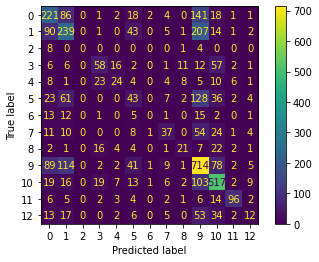

D:\knoor\AnacondaEnvironment\py38tf28\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\knoor\AnacondaEnvironment\py38tf28\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\knoor\AnacondaEnvironment\py38tf28\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0    0.43418   0.44646   0.44024       495
           1    0.42077   0.39635   0.40820       603
           2    0.00000   0.00000   0.00000        13
           3    0.47154   0.33721   0.39322       172
           4    0.40000   0.25532   0.31169        94
           5    0.22513   0.14052   0.17304       306
           6    0.00000   0.00000   0.00000        50
           7    0.45122   0.24667   0.31897       150
           8    0.43750   0.25926   0.32558        81
           9    0.49275   0.67486   0.56961      1058
          10    0.62591   0.72409   0.67143       714
          11    0.82051   0.68085   0.74419       141
          12    0.27907   0.08333   0.12834       144

    accuracy                        0.49291      4021
   macro avg    0.38912   0.32653   0.34496      4021
weighted avg    0.46841   0.49291   0.47093      4021


  • MEDIUM LEVEL 


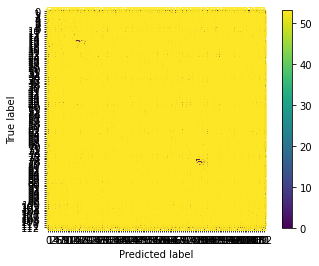

              precision    recall  f1-score   support

           0    0.15152   0.13514   0.14286        37
           1    0.16190   0.19767   0.17801        86
           2    0.35897   0.36842   0.36364        38
           3    0.39130   0.47368   0.42857        19
           4    0.24138   0.16667   0.19718        42
           5    0.23913   0.26829   0.25287        41
           6    0.26531   0.28261   0.27368        46
           7    0.20408   0.20408   0.20408        98
           8    0.00000   0.00000   0.00000        23
           9    0.18978   0.24528   0.21399       106
          10    0.06250   0.05263   0.05714        19
          11    0.07143   0.07692   0.07407        13
          12    0.13636   0.07500   0.09677        40
          13    0.17188   0.18333   0.17742        60
          14    0.11111   0.07595   0.09023        79
          15    0.22222   0.17021   0.19277        47
          16    0.06000   0.05556   0.05769        54
          17    0.38571   0

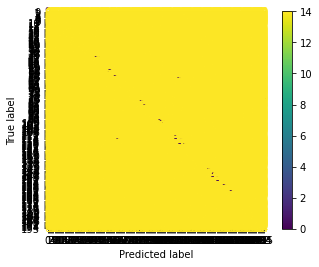

              precision    recall  f1-score   support

           0    0.29032   0.47368   0.36000        19
           1    0.10000   0.15000   0.12000        20
           2    0.09091   0.09524   0.09302        21
           3    0.07143   0.04167   0.05263        24
           4    0.05263   0.04762   0.05000        21
           5    0.15789   0.16667   0.16216        18
           6    0.00000   0.00000   0.00000        19
           7    0.15000   0.13636   0.14286        22
           8    0.04167   0.05556   0.04762        18
           9    0.00000   0.00000   0.00000        20
          10    0.18182   0.26087   0.21429        23
          11    0.02857   0.04762   0.03571        21
          12    0.06250   0.04545   0.05263        22
          13    0.00000   0.00000   0.00000        19
          14    0.05556   0.04762   0.05128        21
          15    0.11111   0.09091   0.10000        22
          16    0.20000   0.20000   0.20000        20
          17    0.05882   0

In [26]:
metrics.lvl_wise_metric(true_label,pred_label)

In [27]:
h_measurements,consistency,exact_match = metrics.hmeasurements(true_label,pred_label,tree)
print('\nHierarchical Precision =',h_measurements[0],
      '\nHierarchical Recall =', h_measurements[1],
      '\nHierarchical F1-Score =',h_measurements[2],
      '\nConsistency = ', consistency,
      '\nExact Match = ', exact_match,
     )


Hierarchical Precision = 0.25540910221337976 
Hierarchical Recall = 0.33267014838763154 
Hierarchical F1-Score = 0.28457838411829955 
Consistency =  0.269087291718478 
Exact Match =  0.07435961203680676
